In [21]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import matplotlib.patches as mpatches

In [22]:
study = "GSE176078"

In [23]:
cell_type = 'B cells Naive'
path = f"../data/brca/tcga/processed/{study}/ct_minor/weights_cell_type_tumor_CID3586.csv"
cell_estimation = pd.read_csv(path,sep=',')
cell_estimation.head()

,B cells Memory,B cells Naive,T cells CD8+,T cells CD4+,NK cells,NKT cells,Monocyte
E2-A1IU,0.004598,0.0,0.0,0.0,0.078833,0.771310,0.145260
AO-A03U,0.004850,0.0,0.0,0.0,0.000000,0.590898,0.404252
E9-A1NH,0.004966,0.0,0.0,0.0,0.000000,0.782599,0.212435
BH-A1EY,0.004965,0.0,0.0,0.0,0.000000,0.633172,0.361863
AO-A1KS,0.004551,0.0,0.0,0.0,0.224304,0.654061,0.117084


In [24]:
cell_estimation.dtypes

B cells Memory    float64
B cells Naive     float64
T cells CD8+      float64
T cells CD4+      float64
NK cells          float64
NKT cells         float64
Monocyte          float64
dtype: object

In [25]:
path = f"../data/brca/tcga/processed/{study}/ct_minor/clinical_cell_type_tumor_CID3586.csv"
survival = pd.read_csv(path,sep=',')
survival = survival.set_index(survival.patientId)
survival.head()

,patientId,SUBTYPE,AJCC_PATHOLOGIC_TUMOR_STAGE,RADIATION_THERAPY,WINTER_HYPOXIA_SCORE,OS_MONTHS,OS_STATUS,DFS_MONTHS,DFS_STATUS
patientId,,,,,,,,,
3C-AAAU,3C-AAAU,BRCA_LumA,STAGE X,No,-28.0,133.050597,0:LIVING,59.440444,1:Recurred/Progressed
3C-AALI,3C-AALI,BRCA_Her2,STAGE IIB,Yes,20.0,131.669790,0:LIVING,131.669790,0:DiseaseFree
3C-AALJ,3C-AALJ,BRCA_LumB,STAGE IIB,No,-10.0,48.459743,0:LIVING,48.459743,0:DiseaseFree
3C-AALK,3C-AALK,BRCA_LumA,STAGE IA,No,4.0,47.604958,0:LIVING,NaN,NaN
4H-AAAK,4H-AAAK,BRCA_LumA,STAGE IIIA,No,-20.0,11.440971,0:LIVING,11.440971,0:DiseaseFree


In [26]:
survival.dtypes

patientId                       object
SUBTYPE                         object
AJCC_PATHOLOGIC_TUMOR_STAGE     object
RADIATION_THERAPY               object
WINTER_HYPOXIA_SCORE           float64
OS_MONTHS                      float64
OS_STATUS                       object
DFS_MONTHS                     float64
DFS_STATUS                      object
dtype: object

In [27]:
survival_test = cell_estimation.merge(survival,left_index=True,right_index=True,how='inner')
survival_test.head()

,B cells Memory,B cells Naive,T cells CD8+,T cells CD4+,NK cells,NKT cells,Monocyte,patientId,SUBTYPE,AJCC_PATHOLOGIC_TUMOR_STAGE,RADIATION_THERAPY,WINTER_HYPOXIA_SCORE,OS_MONTHS,OS_STATUS,DFS_MONTHS,DFS_STATUS
E2-A1IU,0.004598,0.0,0.0,0.0,0.078833,0.771310,0.145260,E2-A1IU,BRCA_LumA,STAGE IA,No,-26.0,11.079331,0:LIVING,11.079331,0:DiseaseFree
AO-A03U,0.004850,0.0,0.0,0.0,0.000000,0.590898,0.404252,AO-A03U,BRCA_Normal,STAGE I,No,-26.0,58.947299,1:DECEASED,58.947299,0:DiseaseFree
E9-A1NH,0.004966,0.0,0.0,0.0,0.000000,0.782599,0.212435,E9-A1NH,BRCA_LumA,STAGE IIB,No,-10.0,18.936779,0:LIVING,18.936779,0:DiseaseFree
BH-A1EY,0.004965,0.0,0.0,0.0,0.000000,0.633172,0.361863,BH-A1EY,BRCA_LumA,STAGE IIA,No,-28.0,17.687477,1:DECEASED,NaN,NaN
AO-A1KS,0.004551,0.0,0.0,0.0,0.224304,0.654061,0.117084,AO-A1KS,BRCA_LumB,STAGE IIA,Yes,-18.0,11.506723,0:LIVING,11.506723,0:DiseaseFree


In [28]:
survival_test = survival_test.rename({"DFS_MONTHS": "DFS", 
                                      "OS_MONTHS":"OS",
                                      "OS_STATUS":"OS_E",
                                      "DFS_STATUS":"DFS_E",
                                     }, axis=1)
survival_test['OS_E'] = pd.to_numeric(survival_test['OS_E'].str.split(':').str[0])
survival_test['DFS_E'] = pd.to_numeric(survival_test['DFS_E'].str.split(':').str[0])
survival_test = survival_test.drop(["patientId"], axis=1)
survival_test.head()

,B cells Memory,B cells Naive,T cells CD8+,T cells CD4+,NK cells,NKT cells,Monocyte,SUBTYPE,AJCC_PATHOLOGIC_TUMOR_STAGE,RADIATION_THERAPY,WINTER_HYPOXIA_SCORE,OS,OS_E,DFS,DFS_E
E2-A1IU,0.004598,0.0,0.0,0.0,0.078833,0.771310,0.145260,BRCA_LumA,STAGE IA,No,-26.0,11.079331,0,11.079331,0.0
AO-A03U,0.004850,0.0,0.0,0.0,0.000000,0.590898,0.404252,BRCA_Normal,STAGE I,No,-26.0,58.947299,1,58.947299,0.0
E9-A1NH,0.004966,0.0,0.0,0.0,0.000000,0.782599,0.212435,BRCA_LumA,STAGE IIB,No,-10.0,18.936779,0,18.936779,0.0
BH-A1EY,0.004965,0.0,0.0,0.0,0.000000,0.633172,0.361863,BRCA_LumA,STAGE IIA,No,-28.0,17.687477,1,NaN,NaN
AO-A1KS,0.004551,0.0,0.0,0.0,0.224304,0.654061,0.117084,BRCA_LumB,STAGE IIA,Yes,-18.0,11.506723,0,11.506723,0.0


In [29]:
survival_test.dtypes

B cells Memory                 float64
B cells Naive                  float64
T cells CD8+                   float64
T cells CD4+                   float64
NK cells                       float64
NKT cells                      float64
Monocyte                       float64
SUBTYPE                         object
AJCC_PATHOLOGIC_TUMOR_STAGE     object
RADIATION_THERAPY               object
WINTER_HYPOXIA_SCORE           float64
OS                             float64
OS_E                             int64
DFS                            float64
DFS_E                          float64
dtype: object

In [30]:
survival_test = survival_test.dropna()

In [31]:
survival_test.shape

(785, 15)

In [32]:
survival_test["B cells Memory"].describe()

count    785.000000
mean       0.017137
std        0.038340
min        0.000000
25%        0.000000
50%        0.003187
75%        0.012116
max        0.400266
Name: B cells Memory, dtype: float64

In [33]:
def generate_levels(df, interest, test_type):
    survival_reorder = df.sort_values(interest,axis=0,ascending=False).copy()
    survival_E = {1:True, 0:False}
    E = list(survival_reorder['%s_E'%test_type])
    E = [survival_E[value] for value in E]
    mid_point = int(len(E)/2)
    E_high = E[:mid_point]
    E_low = E[mid_point:]

    S = list(survival_reorder['%s'%test_type])
    S_high = S[:mid_point]
    S_low = S[mid_point:]    
    dfA = pd.DataFrame({'E': E_high, 'T': S_high, 'low': 0})
    dfB = pd.DataFrame({'E': E_low, 'T': S_low, 'low': 1})
    df = pd.concat([dfA, dfB])
    cph = CoxPHFitter().fit(df, 'T', 'E')
    results = logrank_test(S_high,S_low,E_high,E_low)
    return S_high,S_low,E_high,E_low, cph                                 

In [38]:
def retrieve_stats(cph):
    p = cph.summary["p"].iloc[0]
    hr = cph.hazard_ratios_.iloc[0]
    ci_low = hr + cph.confidence_intervals_.iloc[0,0]
    ci_high = hr + cph.confidence_intervals_.iloc[0,1]
    return p, hr, ci_low, ci_high

In [39]:
survival.describe()

,WINTER_HYPOXIA_SCORE,OS_MONTHS,DFS_MONTHS
count,1078.000000,1080.000000,937.000000
mean,-11.458256,40.812494,37.911767
std,21.022949,39.308977,36.116740
min,-72.000000,0.000000,0.000000
25%,-28.000000,14.720387,14.268337
50%,-14.000000,27.073676,24.986028
75%,2.000000,55.002137,50.958346
max,78.000000,282.901009,281.290068


In [40]:
survival_test.columns

Index(['B cells Memory', 'B cells Naive', 'T cells CD8+', 'T cells CD4+',
       'NK cells', 'NKT cells', 'Monocyte', 'SUBTYPE',
       'AJCC_PATHOLOGIC_TUMOR_STAGE', 'RADIATION_THERAPY',
       'WINTER_HYPOXIA_SCORE', 'OS', 'OS_E', 'DFS', 'DFS_E'],
      dtype='object')

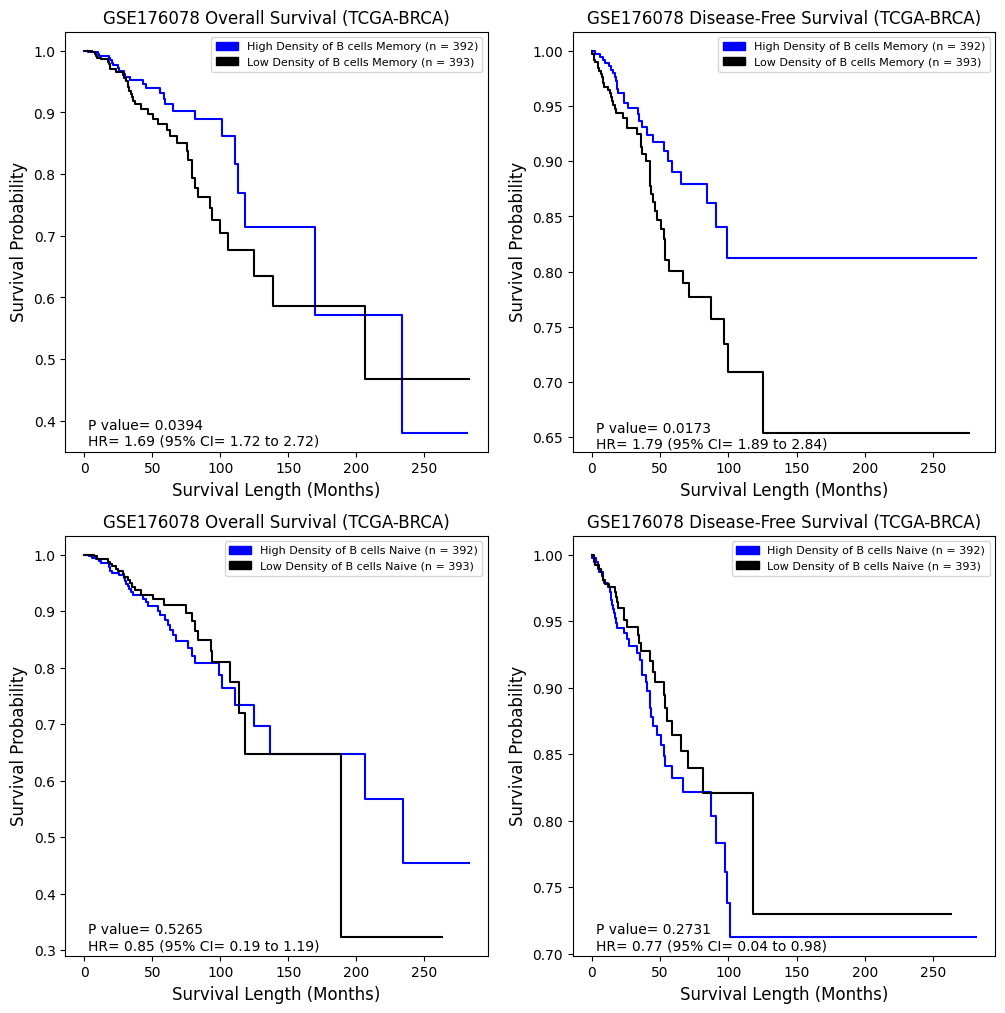

In [49]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# subplot 1
cell_type = 'B cells Memory'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[0, 0].step(*kmf(E_high, S_high), c='b')
axs[0, 0].step(*kmf(E_low, S_low), c='k')
#axs[0, 0].set_xticks(np.arange(0, 73, 24))
#axs[0, 0].set_yticks(np.arange(0.2, 1.1, 0.2))
axs[0, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 0].text(3,0.36, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[0, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 2
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[0, 1].step(*kmf(E_high, S_high), c='b')
axs[0, 1].step(*kmf(E_low, S_low), c='k')
axs[0, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 1].text(3,0.64, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[0, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)

# subplot 3
cell_type = 'B cells Naive'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[1, 0].step(*kmf(E_high, S_high), c='b')
axs[1, 0].step(*kmf(E_low, S_low), c='k')
axs[1, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 0].text(3,0.3, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[1, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 4
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[1, 1].step(*kmf(E_high, S_high), c='b')
axs[1, 1].step(*kmf(E_low, S_low), c='k')
axs[1, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 1].text(3,0.703, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[1, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)
path = f"../figures/{study}/With_No_Other/B_cell_survival_logranktest.png"
plt.savefig(path,format='png')
plt.show()
plt.close()


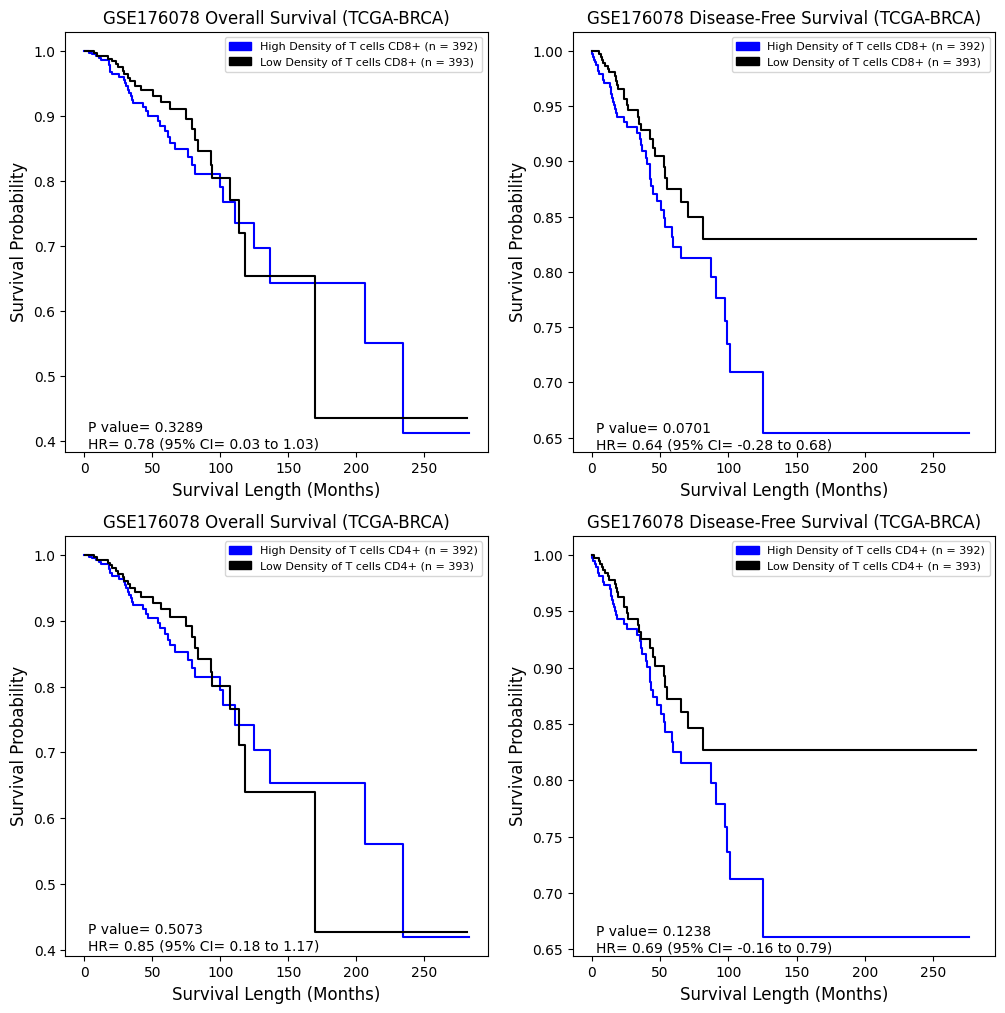

In [61]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# subplot 1
cell_type = 'T cells CD8+'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[0, 0].step(*kmf(E_high, S_high), c='b')
axs[0, 0].step(*kmf(E_low, S_low), c='k')
#axs[0, 0].set_xticks(np.arange(0, 73, 24))
#axs[0, 0].set_yticks(np.arange(0.2, 1.1, 0.2))
axs[0, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 0].text(3,0.39, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[0, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 2
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[0, 1].step(*kmf(E_high, S_high), c='b')
axs[0, 1].step(*kmf(E_low, S_low), c='k')
axs[0, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 1].text(3,0.64, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[0, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)

# subplot 3
cell_type = 'T cells CD4+'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[1, 0].step(*kmf(E_high, S_high), c='b')
axs[1, 0].step(*kmf(E_low, S_low), c='k')
axs[1, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 0].text(3,0.4, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[1, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 4
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[1, 1].step(*kmf(E_high, S_high), c='b')
axs[1, 1].step(*kmf(E_low, S_low), c='k')
axs[1, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 1].text(3,0.648, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[1, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)
path = f"../figures/{study}/With_No_Other/T_cell_survival_logranktest.png"
plt.savefig(path,format='png')
plt.show()
plt.close()


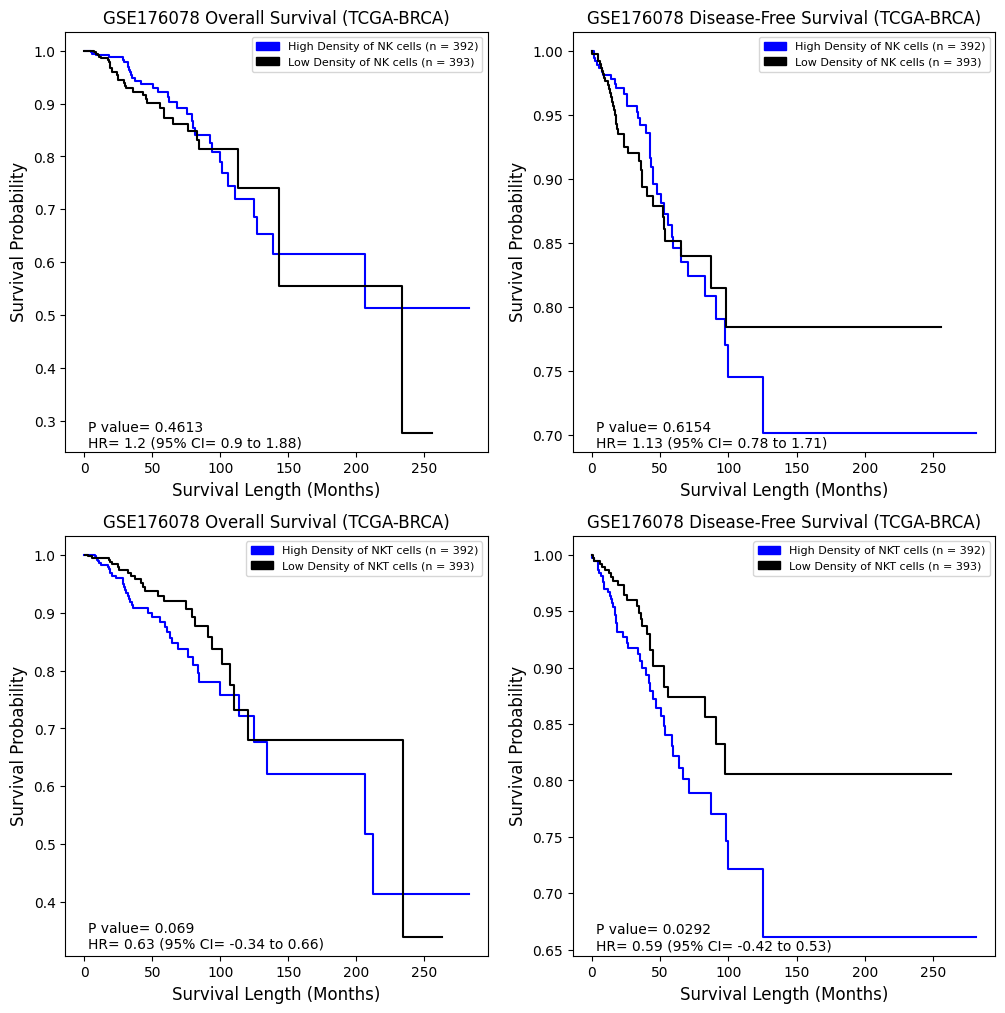

In [66]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# subplot 1
cell_type = 'NK cells'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[0, 0].step(*kmf(E_high, S_high), c='b')
axs[0, 0].step(*kmf(E_low, S_low), c='k')
#axs[0, 0].set_xticks(np.arange(0, 73, 24))
#axs[0, 0].set_yticks(np.arange(0.2, 1.1, 0.2))
axs[0, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 0].text(3,0.25, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[0, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 2
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[0, 1].step(*kmf(E_high, S_high), c='b')
axs[0, 1].step(*kmf(E_low, S_low), c='k')
axs[0, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 1].text(3,0.69, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[0, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)

# subplot 3
cell_type = 'NKT cells'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[1, 0].step(*kmf(E_high, S_high), c='b')
axs[1, 0].step(*kmf(E_low, S_low), c='k')
axs[1, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 0].text(3,0.32, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[1, 0].set_title(f'{study} Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 4
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[1, 1].step(*kmf(E_high, S_high), c='b')
axs[1, 1].step(*kmf(E_low, S_low), c='k')
axs[1, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 1].text(3,0.65, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[1, 1].set_title(f'{study} Disease-Free Survival (TCGA-BRCA)', fontsize=12)
path = f"../figures/{study}/With_No_Other/NK_cell_survival_logranktest.png"
plt.savefig(path,format='png')
plt.show()
plt.close()
